# Drive-it DQN

After a transition $(s,a,r,s′)$, we are trying to move our value function $Q(s,a)$ closer to our target $r+\gamma \max_{a′}Q(s′,a′)$, where $\gamma$ is a discount factor for future rewards and ranges in value between 0 and 1.

DQNs
 * learn the _Q-function_ that maps observation (state, action) to a `score`
 * use prioritized memory replay (previously recorded $Q$ values corresponding to differnt $(s,a)$ to decorrelate experiences (sequence state transitions)
 * use a second network to stabilize learning

## Model
\begin{equation}
l_1 = relu( x W_1 + b_1) \\
l_2 = relu( x W_2 + b_2) \\
l_3 = relu( x W_3 + b_3) \\
Q(s,a) = l_1 W_o + b_o \\
\end{equation}

In [1]:
import random, numpy, math
from cntk import *
from cntk.models import Sequential
from cntk.layers import *
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('ggplot')
%matplotlib inline
sns.set()

In [2]:
class Brain:
    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt
        self._createModel()
        self.lr = 0.5
        self.momentum = 0.9
        self._createTrainer()
        self.updateTargetModel()
        
    def _createModel(self):
        observation = input_variable(self.stateCnt, np.float32, name="s")
        q_target = input_variable(self.actionCnt, np.float32, name="q")

        l1 = Dense(128, activation=relu)
        l2 = Dense(128, activation=relu)
        lo = Dense(self.actionCnt)
        unbound_model = Sequential([l1, l2, lo])
        self.model = unbound_model(observation)

        # this is to enable plotting the network parameters
        self.params = dict(W1=l1.W, b1=l1.b, W2=l2.W, b2=l2.b)
        
        # hubert loss -- turns out it does not work well wit this problem
        #loss = reduce_mean(sqrt(1 + square(model - q_target)) -1, axis=0)
        #meas = reduce_mean(sqrt(1 + square(model - q_target)) -1, axis=0)
        
        # MSE loss
        self.loss = reduce_mean(square(self.model - q_target), axis=0)
        self.eval_function = reduce_mean(square(self.model - q_target), axis=0)

        # learning rate schedule sems to be broken in this version of the tookit
        # so we use functions below to update it manually
        #lr = [0.01, 0.005, 0.0025, 0.001]
        #lr_schedule = learning_rate_schedule(lr, UnitType.minibatch, epoch_size=5000)
        #learner = sgd(self.model.parameters, lr_schedule, gradient_clipping_threshold_per_sample=10)
        #trainer = Trainer(self.model, self.loss, self.eval_function, learner)
    
    def _createTrainer(self):
        lr_schedule = learning_rate_schedule(self.lr, UnitType.minibatch)
        #learner = sgd(self.model.parameters, lr_schedule, \
        #              gradient_clipping_threshold_per_sample=10)
        momentum = momentum_schedule(self.momentum)
        learner = momentum_sgd(self.model.parameters, lr_schedule, momentum, \
                               gradient_clipping_threshold_per_sample=10)
        #learner = adam_sgd(self.model.parameters, lr_schedule, momentum, \
        #                   gradient_clipping_threshold_per_sample=10)
        self.trainer = Trainer(self.model, self.loss, self.eval_function, learner)

    def updateLearningRate(self, lr):
        self.lr = lr
        self._createTrainer()
    
    def train(self, x, y):
        arguments = dict(zip(self.loss.arguments, [y,x]))
        return self.trainer.train_minibatch(arguments, outputs=[self.loss.output])

    def predict(self, s, target=False):
        if target:
            return self.model_.eval(s)
        else:
            return self.model.eval(s)

    def predictOne(self, s, target=False):
        return self.predict(s.reshape(1, self.stateCnt), target=target).flatten()

    def updateTargetModel(self):
        self.model_ = self.model.clone(method='clone')
        
    def saveModel(self, path):
        self.model.save_model(path, False)
        
    def loadModel(self, path):
        self.model = load_model(path)
        self._createTrainer()

## Agent
The `Agent` uses the `Brain` and `Memory` to replay the past actions to choose optimal set of actions that maximize the rewards.

In [3]:
MAX_EPSILON = 1.0
MIN_EPSILON = 0.01 # stay a bit curious even when getting old
EXPLORATION_STOP = 2000000   # at this step epsilon will be MIN_EPSILON
LAMBDA = - math.log(0.01) / EXPLORATION_STOP  # speed of decay

In [4]:
MEMORY_CAPACITY = 5000000
BATCH_SIZE_PER_SAMPLE = 8
UPDATE_TARGET_FREQUENCY = 10000
GAMMA = 0.98 # discount factor

from Memory import SumTreeMemory

class Agent:
    steps = 0
    episodes = 0
    epsilon = MAX_EPSILON
    lastTargetUpdateStep = 0
    episode = []

    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt
        
        #       0   .3   .6    .9   1.2   1.5   1.8   2.1   2.4
        lr = [0.5, 0.2, 0.1, 0.05, 0.02, 0.02, 0.01, 0.01, 0.005]
        self.epoch_size = 300000
        self.lr_schedule \
        = learning_rate_schedule(lr, UnitType.sample, epoch_size=self.epoch_size)

        self.brain = Brain(stateCnt, actionCnt)
        self.memory = SumTreeMemory(MEMORY_CAPACITY)
        
    def act(self, s):
        if random.random() < self.epsilon:
            return random.randint(0, self.actionCnt - 1)
        else:
            return np.argmax(self.brain.predictOne(s))

    def observe(self, sample):  # in (s, a, r, s_) format
        self.episode.insert(0, sample)
        self.steps += 1

        # update the learning rate
        # until the toolkit's learning rate schedule bug is fixed
        if self.steps % self.epoch_size == 0:
            self.brain.updateLearningRate(self.lr_schedule[self.steps])

    def endEpisode(self):
        n = len(self.episode)
        if n == 0: return

        # calculate Q_min values for the episode steps
        q = 0
        batch = []
        for i in range(n):
            s, a, r, s_ = self.episode[i]
            q = r + GAMMA * q
            batch.append((s, a, r, s_, q)) 
        
        # get the target model error on the steps for prioritized replay 
        x, y, err = self._getTargets(batch)
        
        # add steps to memory, prioritized by error
        for i in range(len(batch)):
            self.memory.add(err[i], batch[i])
        
        self.episode = []
        self.episodes += 1

        # slowly decrease epsilon based on our eperience
        self.epsilon = MIN_EPSILON \
        + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)
        
        # memory replay based on the number of steps in the episode
        self.replay(int(n * BATCH_SIZE_PER_SAMPLE))
        
    def _getTargets(self, batch):
        no_state = np.zeros(self.stateCnt)
        states = np.array([ o[0] for o in batch ], dtype=np.float32)
        states_ = np.array([ (no_state if o[3] is None else o[3]) \
                            for o in batch ], dtype=np.float32)

        p = agent.brain.predict(states)[0]
        p_ = agent.brain.predict(states_, target = False)[0]
        pTarget_ = agent.brain.predict(states_, target = True)[0]

        x = np.zeros((len(batch), self.stateCnt)).astype(np.float32)
        y = np.zeros((len(batch), self.actionCnt)).astype(np.float32)
        err = np.zeros(len(batch))

        for i in range(len(batch)):
            s, a, r, s_, q = batch[i]

            t = p[i]
            if s_ is None:
                ta = r
            else:
                #ta = r + GAMMA * pTarget_[i][ np.argmax(p_[i]) ]  # double DQN
                ta = max(q, r + GAMMA * pTarget_[i][ np.argmax(p_[i]) ]) # Q-min DDQN

            err[i] = np.abs(t[a] - ta)
            t[a] = ta
            x[i] = s
            y[i] = t
            
        return (x, y, err)
        
    def replay(self, size):
        # eriodically update the target network
        if self.steps - self.lastTargetUpdateStep >= UPDATE_TARGET_FREQUENCY:
            self.brain.updateTargetModel()
            self.lastTargetUpdateStep = self.steps
        
        # get samples batch and train over the targets
        indexes, batch = self.memory.sample(size)
        x, y, err = self._getTargets(batch)
        self.brain.train(x, y)
        
        # update the batch steps errors in memory
        for i in range(len(batch)):
            self.memory.update(indexes[i], err[i])

## Visualization
Model weights visualization:

In [5]:
def plot_weights(weights, figsize=(7,5)):
    '''Heat map of weights to see which neurons play which role'''
    f, ax = plt.subplots(len(weights), figsize=figsize)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    for i, data in enumerate(weights):
        axi = ax if len(weights)==1 else ax[i]
        if isinstance(data, tuple): 
            w, title = data
            axi.set_title(title)
        else:
            w = np.asarray(data)
        sns.heatmap(w, cmap=cmap, square=True, center=True, #annot=True,
                    linewidths=.5, cbar_kws={"shrink": .25}, ax=axi)

We use PCA decomposition on memory samples to visualize the $Q(s,a)$ values across the state space: 

In [6]:
def pca_plot(n=10000, alpha=1.0, size=5):
    _, samples = agent.memory.sample(n)
    states = np.array([ o[0] for o in samples ], dtype=np.float32)
    qsa = agent.brain.predict(states)[0]
    
    from sklearn import decomposition
    pca = decomposition.PCA(n_components=2)
    pca.fit(states)
    X = pca.transform(states)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    ax = axes[0,0]; plt.sca(ax);ax.set_title('Action')
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(qsa, 1), alpha=alpha, s=size, cmap="rainbow")
    ax = axes[0,1]; plt.sca(ax);ax.set_title('Q(s,no-change)')
    plt.scatter(X[:, 0], X[:, 1], c=qsa[:,0], alpha=alpha, s=size, cmap="rainbow")    
    ax = axes[1,0]; plt.sca(ax);ax.set_title('Q(s,left)')
    plt.scatter(X[:, 0], X[:, 1], c=qsa[:,1], alpha=alpha, s=size, cmap="rainbow")    
    ax = axes[1,1]; plt.sca(ax);ax.set_title('Q(s,right)')
    plt.scatter(X[:, 0], X[:, 1], c=qsa[:,2], alpha=alpha, s=size, cmap="rainbow")
    plt.show()

In [64]:
def cloud_plot(n=10000, alpha=1.0, size=5):
    _, samples = agent.memory.sample(n)
    states = np.array([ o[0] for o in samples ], dtype=np.float32)
    qsa = agent.brain.predict(states)[0]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    ax = axes[0,0]; plt.sca(ax);ax.set_title('Action')
    plt.scatter(states[:, 0], states[:, 1], c=np.argmax(qsa, 1), alpha=alpha, s=size, cmap="rainbow")
    ax = axes[0,1]; plt.sca(ax);ax.set_title('Q(s,no-change)')
    plt.scatter(states[:, 0], states[:, 1], c=qsa[:,0], alpha=alpha, s=size, cmap="rainbow")    
    ax = axes[1,0]; plt.sca(ax);ax.set_title('Q(s,left)')
    plt.scatter(states[:, 0], states[:, 1], c=qsa[:,1], alpha=alpha, s=size, cmap="rainbow")    
    ax = axes[1,1]; plt.sca(ax);ax.set_title('Q(s,right)')
    plt.scatter(states[:, 0], states[:, 1], c=qsa[:,2], alpha=alpha, s=size, cmap="rainbow")
    plt.show()

Alternatively, we can generate heatmaps over a slize of the state space:

In [8]:
def slice_heatmaps(steer = 0.0, b_rl = 0.0):
    dpi = 301
    D = np.linspace(-1.0, 1.0, dpi)
    TH = np.linspace(-1.0, 1.0, dpi)

    samples = np.array([(d, th, steer, b_rl) for d in D for th in TH]).astype(np.float32)
    qsa = agent.brain.predict(samples)
    za = np.argmax(qsa,2).reshape((dpi,dpi))
    z0 = qsa[:,:,0].reshape((dpi,dpi))
    z1 = qsa[:,:,1].reshape((dpi,dpi))
    z2 = qsa[:,:,2].reshape((dpi,dpi))
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2.5))
    sns.heatmap(za, cmap="rainbow", xticklabels=False, yticklabels=False, cbar=False, ax=axes[0])
    axes[0].set_title('Action')
    sns.heatmap(z0, cmap="rainbow", xticklabels=False, yticklabels=False, cbar=False, ax=axes[1], vmin=-2.35, vmax=2.35)
    axes[1].set_title('Q(s,no-change)')
    sns.heatmap(z1, cmap="rainbow", xticklabels=False, yticklabels=False, cbar=False, ax=axes[2], vmin=-2.35, vmax=2.35)
    axes[2].set_title('Q(s,left)')
    sns.heatmap(z2, cmap="rainbow", xticklabels=False, yticklabels=False, cbar=False, ax=axes[3], vmin=-2.35, vmax=2.35)
    axes[3].set_title('Q(s,right)')
    for ax in axes:
        ax.set_xlabel('$distance$')
        ax.set_ylabel('$heading$')
    plt.show()

## Training

In [9]:
def run_episode(agent, render=False):
    s = env.reset()
    R = 0 
    while True:            
        if render: env.render()

        a = agent.act(s.astype(np.float32))
        s_, r, done, info = env.step(a)
        
        if done:
            s_ = None

        agent.observe((s, a, r, s_))
        s = s_
        R += r

        if done:
            agent.endEpisode()
            return R

In [10]:
from DriveItGym import DriveItEnv

BATCH_SIZE = 20000

env = DriveItEnv(time_limit=10.0, throttle_limit=1.0, show_true_median_pos=False)
stateCnt  = env.observation_space.shape[0]
actionCnt = env.action_space.n
agent = Agent(stateCnt, actionCnt)

episode_number = 0
last_batch_episode = 0
last_batch_steps = 0
episodes = []
reward_sum = 0
reward_best = 18.0

(stateCnt, actionCnt)

(4, 3)

In [11]:
while episode_number < 15000 and agent.steps < 2500000:
    episode_number += 1
    reward = run_episode(agent, render=False)
    reward_sum += reward
    
    if agent.steps >= last_batch_steps + BATCH_SIZE:
        reward_avg = reward_sum / (episode_number - last_batch_episode)
        last_batch_episode = episode_number
        last_batch_steps = int(agent.steps / BATCH_SIZE) * BATCH_SIZE
        episodes.append((episode_number, agent.steps, reward_avg))

        print('Episode: %d, steps: %d, epsilon: %f, average reward: %f.' \
              % (episode_number, agent.steps, agent.epsilon, reward_avg))
        
        if reward_avg > reward_best:
            reward_best = reward_avg
            agent.brain.model.save_model('best.mod', False)

        if reward_avg >= 20.0:
            print('Task solved in %d episodes' % episode_number)
            break

        reward_sum = 0
       
agent.brain.model.save_model('last.mod', False)
print('Done.')

Episode: 1020, steps: 20070, epsilon: 0.955290, average reward: -1.523179.
Episode: 2000, steps: 40003, epsilon: 0.912884, average reward: -1.505132.
Episode: 2897, steps: 60012, epsilon: 0.872230, average reward: -1.457143.
Episode: 3735, steps: 80036, epsilon: 0.833378, average reward: -1.409729.
Episode: 4482, steps: 100015, epsilon: 0.796358, average reward: -1.316743.
Episode: 5214, steps: 120010, epsilon: 0.760975, average reward: -1.314798.
Episode: 5883, steps: 140091, epsilon: 0.727041, average reward: -1.220796.
Episode: 6468, steps: 160054, epsilon: 0.694828, average reward: -1.110525.
Episode: 7076, steps: 180008, epsilon: 0.664074, average reward: -1.148803.
Episode: 7581, steps: 200054, epsilon: 0.634570, average reward: -0.931303.
Episode: 8056, steps: 220048, epsilon: 0.606468, average reward: -0.866520.
Episode: 8493, steps: 240014, epsilon: 0.579667, average reward: -0.746699.
Episode: 8893, steps: 260013, epsilon: 0.554029, average reward: -0.608169.
Episode: 9223, s

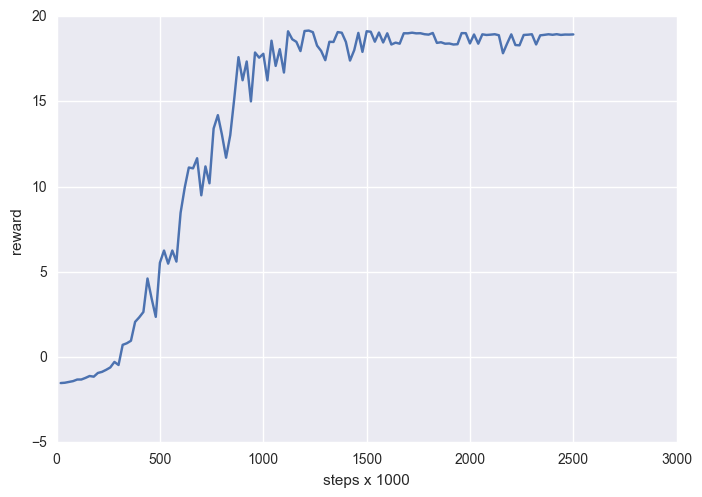

In [14]:
plt.plot([e[1]/1000 for e in episodes], [e[2] for e in episodes])
plt.xlabel('steps x 1000');plt.ylabel('reward')

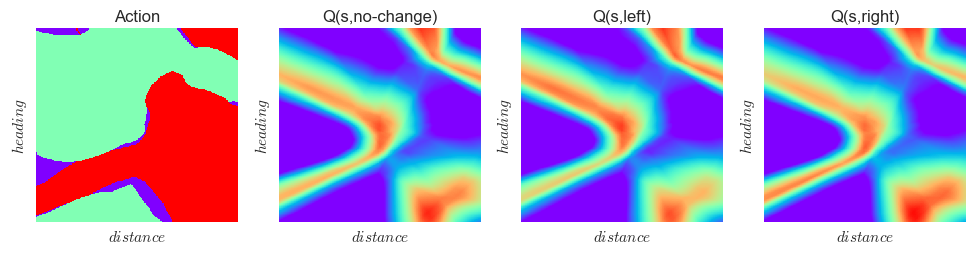

In [13]:
slice_heatmaps(steer=0.0, b_rl=0.0)

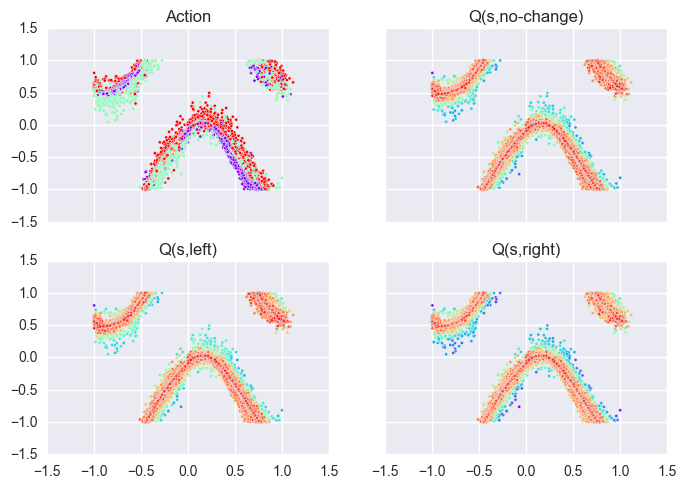

In [65]:
cloud_plot(n=10000, size=5)

Increased epoch size.

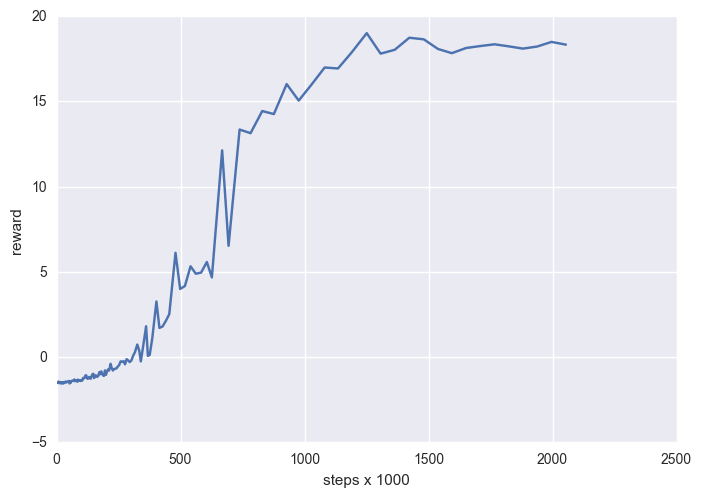

In [12]:
plt.plot([e[0]/1000 for e in episodes], [e[1] for e in episodes])
plt.xlabel('steps x 1000');plt.ylabel('reward')

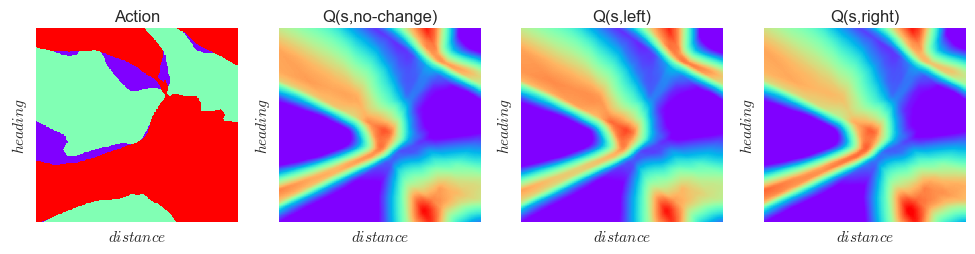

In [13]:
slice_heatmaps(steer=0.0, b_rl=0.0)

Added bias error on heading, tuned lr schedule.

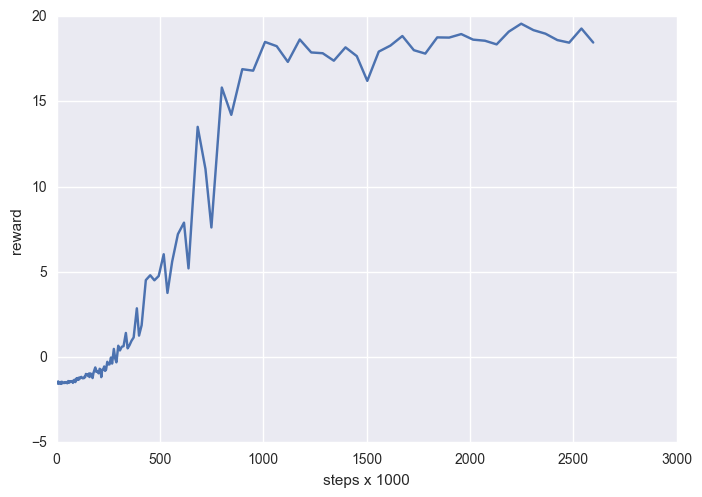

In [14]:
plt.plot([e[0]/1000 for e in episodes], [e[1] for e in episodes])
plt.xlabel('steps x 1000');plt.ylabel('reward')

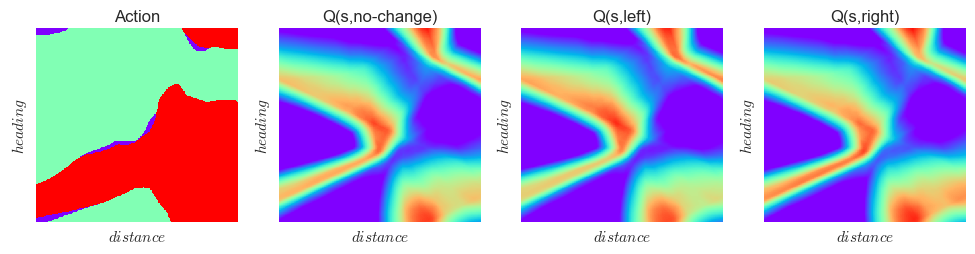

In [15]:
slice_heatmaps(steer=0.0, b_rl=0.0)

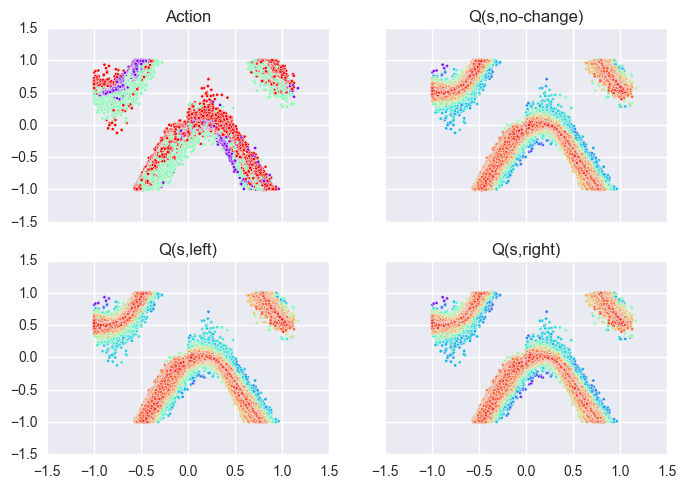

In [16]:
cloud_plot(n=50000, size=5)

Tuned learning rate schedule.

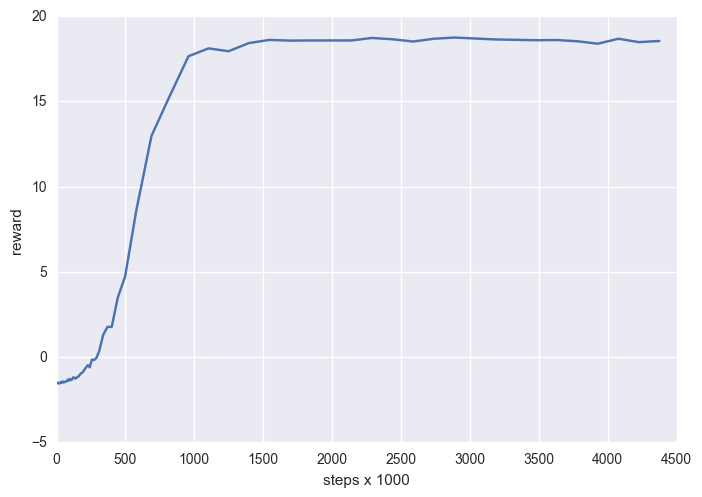

In [64]:
plt.plot([e[0]/1000 for e in episodes], [e[1] for e in episodes])
plt.xlabel('steps x 1000');plt.ylabel('reward')

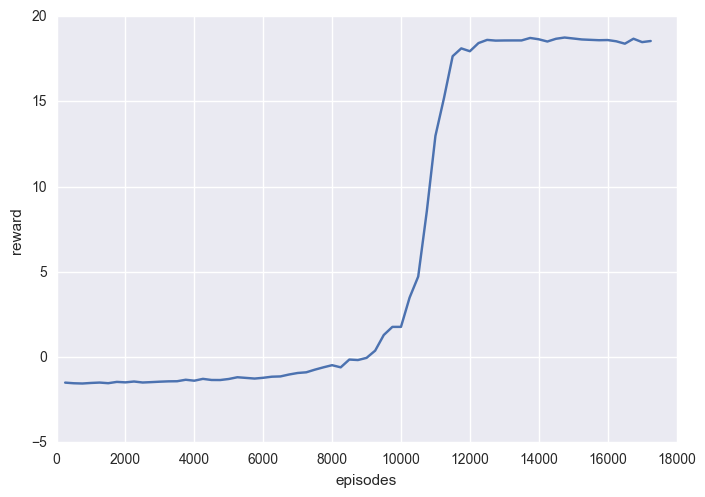

In [65]:
plt.plot([(i + 1) * BATCH_SIZE for i in range(len(episodes))], [e[1] for e in episodes])
plt.xlabel('episodes');plt.ylabel('reward')

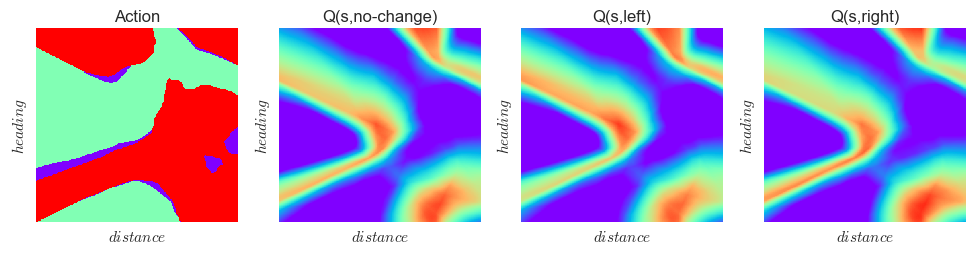

In [66]:
slice_heatmaps(steer=0.0, b_rl=0.0)

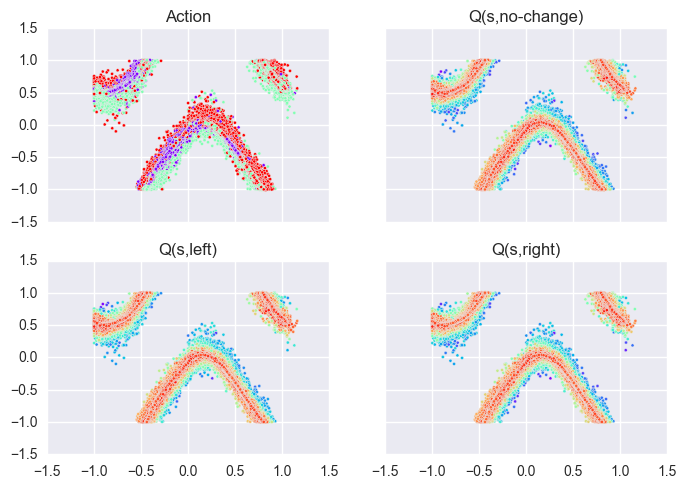

In [94]:
cloud_plot(n=50000, size=5)

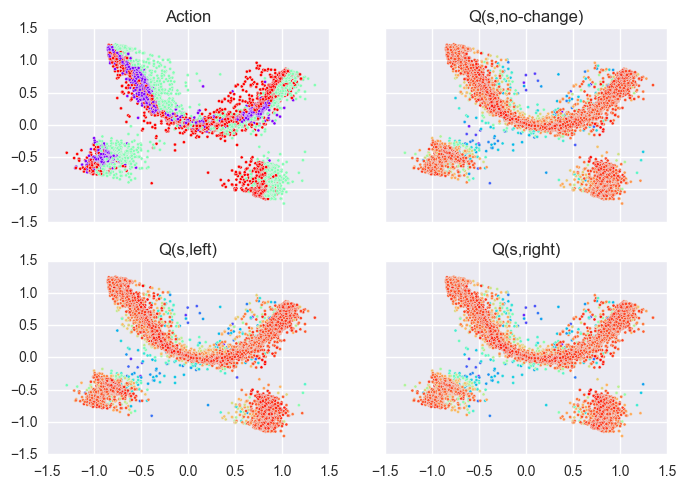

In [67]:
pca_plot(n=10000, alpha=1.0, size=5)

Faster espilon decay.

Epsilon decay based on steps. Variable learning rate with fixed momentum.

Slow down learning rate decay.

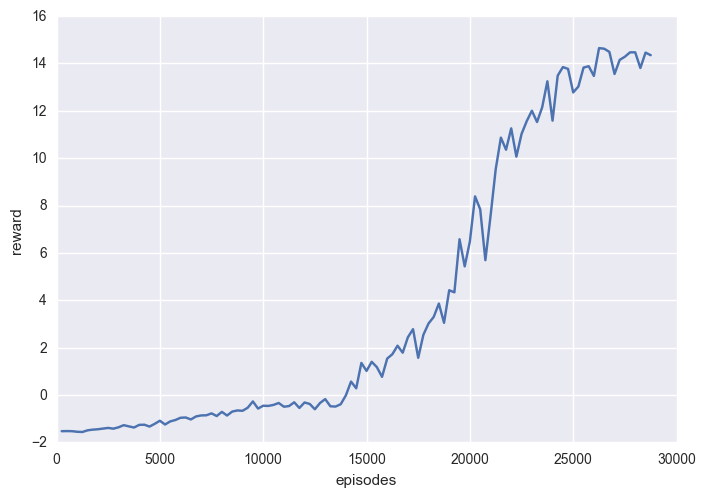

In [27]:
plt.plot([(i + 1) * BATCH_SIZE for i in range(len(episodes))], [e[1] for e in episodes])
plt.xlabel('episodes');plt.ylabel('reward')

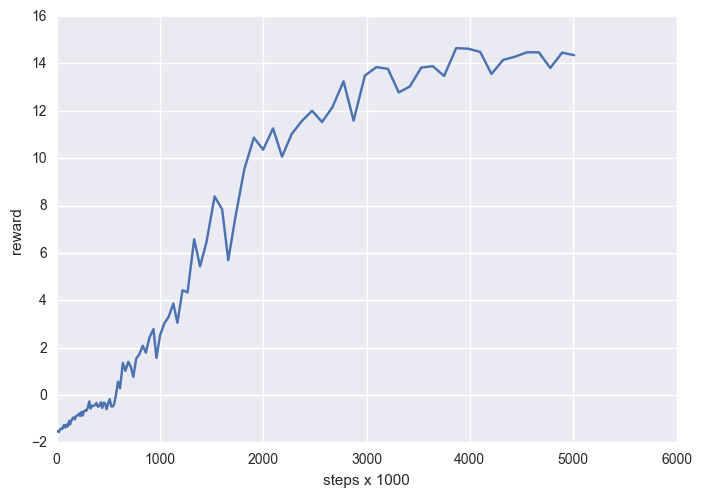

In [28]:
plt.plot([e[0]/1000 for e in episodes], [e[1] for e in episodes])
plt.xlabel('steps x 1000');plt.ylabel('reward')

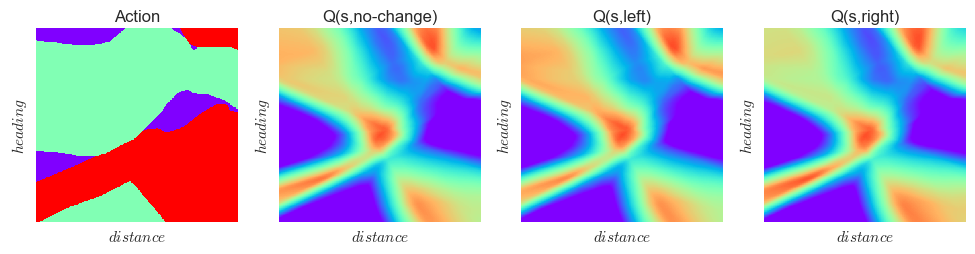

In [29]:
slice_heatmaps(steer=0.0, b_rl=0.0)

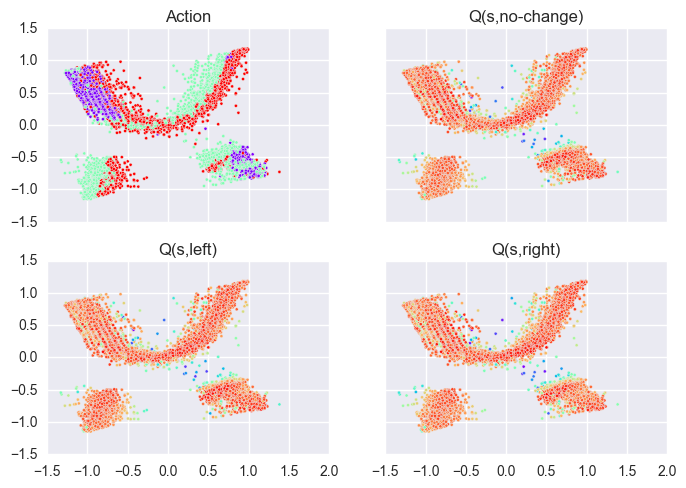

In [30]:
pca_plot(n=10000, alpha=1.0, size=5)

Removed blueness reward.

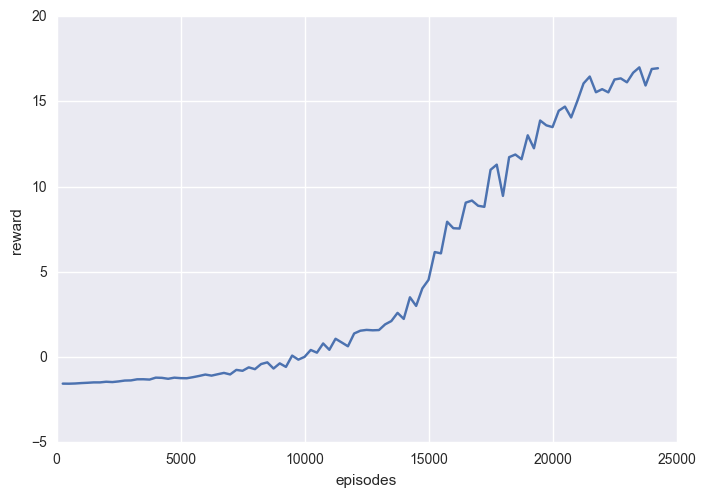

In [11]:
plt.plot([(i + 1) * BATCH_SIZE for i in range(len(episodes))], [e[1] for e in episodes])
plt.xlabel('episodes');plt.ylabel('reward')

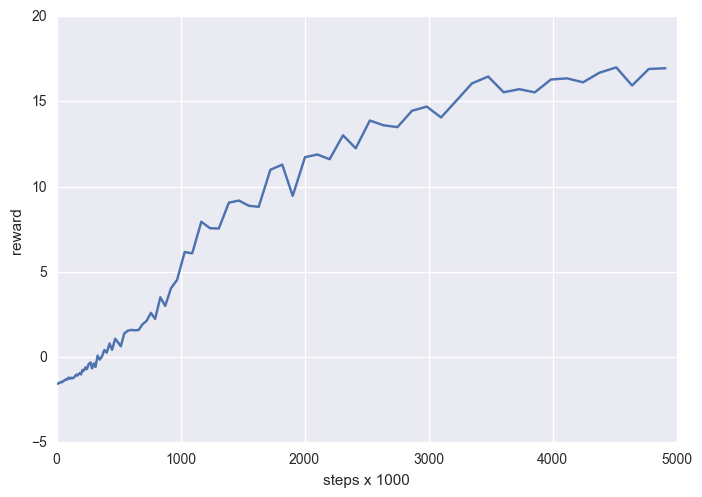

In [12]:
plt.plot([e[0]/1000 for e in episodes], [e[1] for e in episodes])
plt.xlabel('steps x 1000');plt.ylabel('reward')

Lowered action step size.

Back to two layer network, but larger, and lower exploration stop.

---

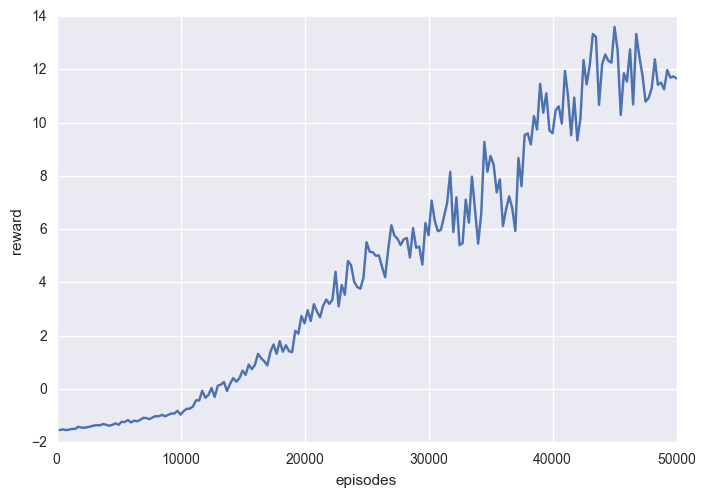

In [22]:
plt.plot([(i + 1) * BATCH_SIZE for i in range(len(episodes))], [e[1] for e in episodes])
plt.xlabel('episodes');plt.ylabel('reward')

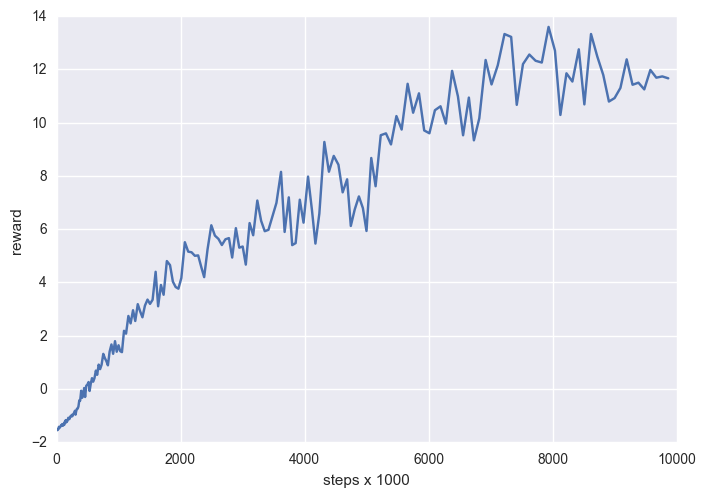

In [25]:
plt.plot([e[0]/1000 for e in episodes], [e[1] for e in episodes])
plt.xlabel('steps x 1000');plt.ylabel('reward')

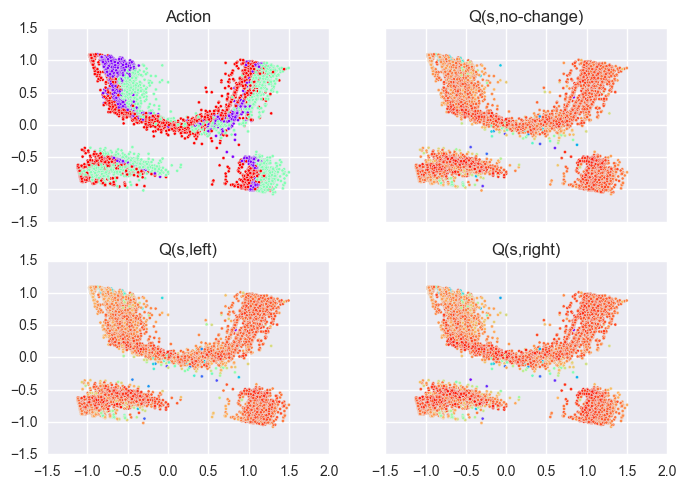

In [23]:
pca_plot(n=10000, alpha=1.0, size=5)

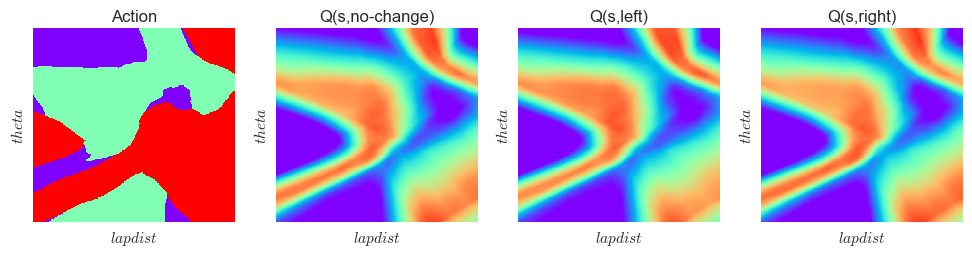

In [24]:
slice_heatmaps(steer=0.0, b_rl=0.0)

3-layer network.

---

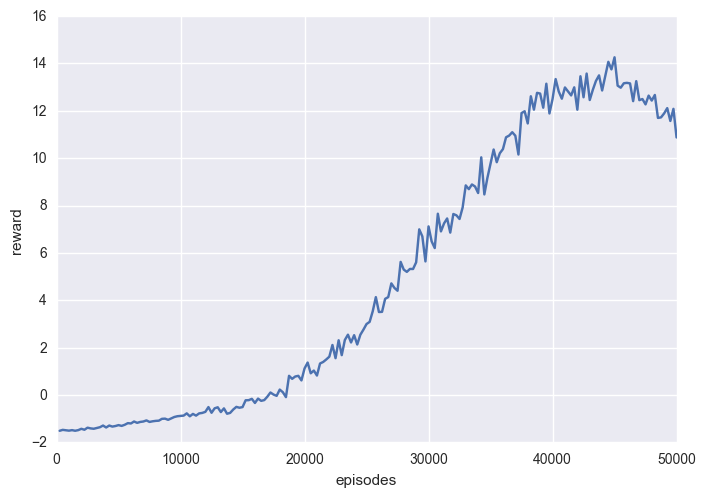

In [26]:
plt.plot([(i + 1) * BATCH_SIZE for i in range(len(episodes))], [e[1] for e in episodes])
plt.xlabel('episodes');plt.ylabel('reward')

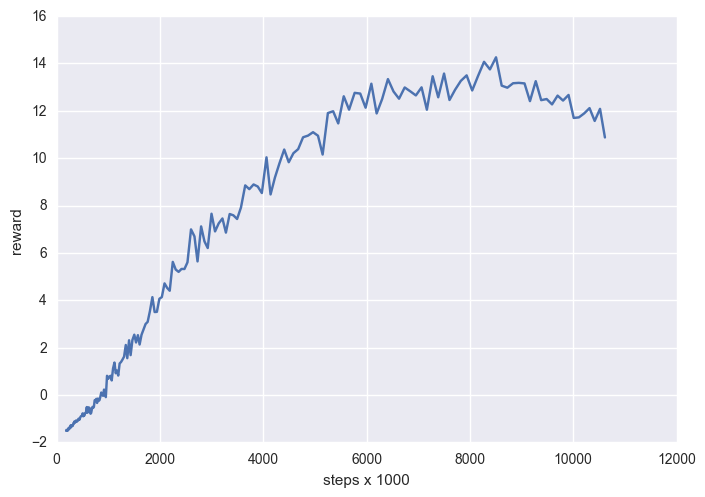

In [38]:
plt.plot([e[0]/1000 for e in episodes], [e[1] for e in episodes])
plt.xlabel('steps x 1000');plt.ylabel('reward')

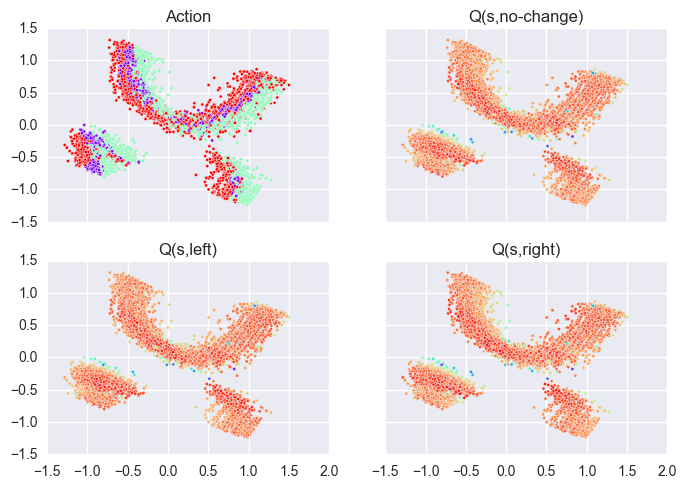

In [48]:
pca_plot(n=10000, alpha=1.0, size=5)

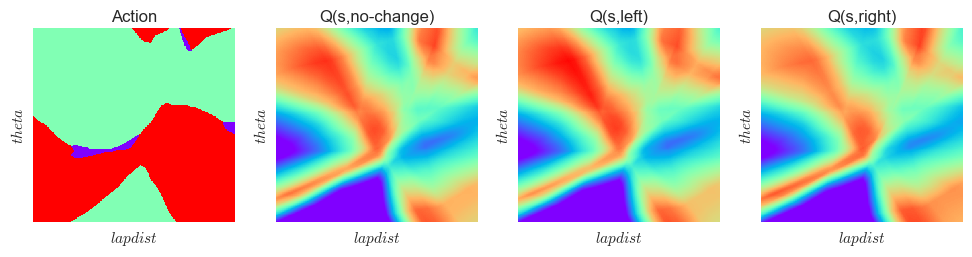

In [47]:
slice_heatmaps(steer=0.0, b_rl=0.0)

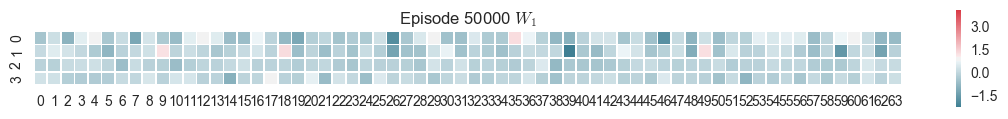

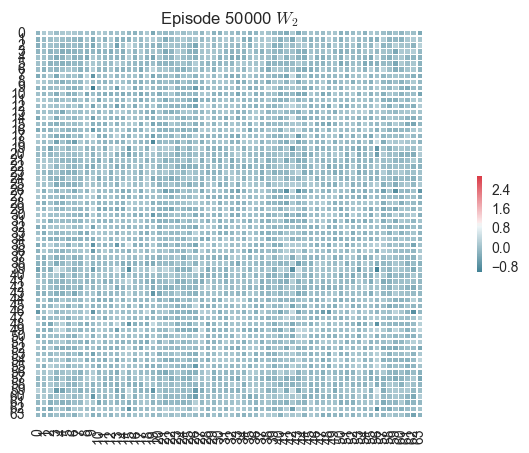

In [44]:
plot_weights([(agent.brain.params['W1'], \
               'Episode %i $W_1$'%episode_number)], figsize=(14,5))            
plot_weights([(agent.brain.params['W2'], \
               'Episode %i $W_2$'%episode_number)], figsize=(14,5))

In [ ]:
#agent.brain.loadModel('best.mod')

### Exploration - exploitation trade-off

Note initiall $\epsilon$ is set to 1 which implies we are enitrely exploraing but as steps increase we reduce exploration and start leveraging the learnt space to collect rewards (a.k.a exploitation) as well.

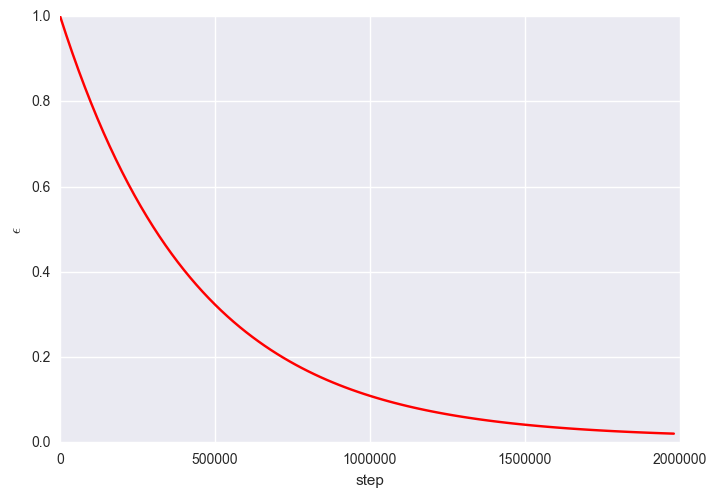

In [11]:
def epsilon(steps):
    return MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-LAMBDA * steps)

r = range(0,EXPLORATION_STOP,int(EXPLORATION_STOP/100))
plt.plot(r, [min(epsilon(x),1) for x in r], 'r')
#plt.plot(r, [min(epsilon(x),1)**EPSILON_TRAIN_FACTOR for x in r], 'b')
plt.xlabel('step');plt.ylabel('$\epsilon$')

## Discounted Reward

0.98

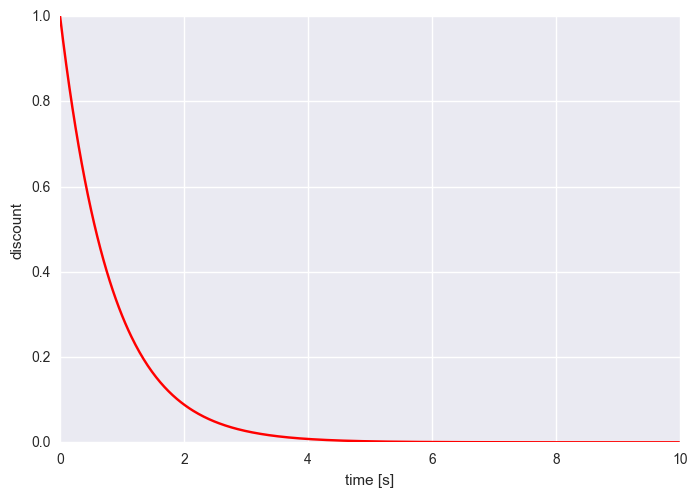

In [11]:
r = range(0,600)
plt.plot([t/60.0 for t in r], [GAMMA ** x for x in r], 'r')
plt.xlabel('time [s]');plt.ylabel('discount')
GAMMA